In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import analysis_pca
from sklearn import linear_model

Ts = 1000
data_path = r'C:\Users\IBS\Desktop\python_code_N2'
save_path = r'C:\Users\IBS\Desktop\figures'

In [2]:
# Path to your Excel file
SOURCE_DATA_SF3 = 'SupplementaryFigure3.xlsx'

# Read specific sheet and ranges
mf = pd.read_excel(SOURCE_DATA_SF3, sheet_name='Figure S3b,c,d,f', usecols='A:HY', skiprows=2, nrows=502)
pc = pd.read_excel(SOURCE_DATA_SF3, sheet_name='Figure S3b,c,d,f', usecols='HZ:TP', skiprows=2, nrows=502)

In [3]:
# rate is ssc0, drate is wv0
lm_MF = {
    'rate': mf.iloc[:, 0:116].to_numpy().T,
    'drate': mf.iloc[:, 116:232].to_numpy().T,
    'v0': mf.iloc[0, 232],
    'label': 'MF'
}

lm_PC = {
    'rate': pc.iloc[:, 0:151].to_numpy().T,
    'drate': pc.iloc[:, 151:302].to_numpy().T,
    'v0': pc.iloc[0, 302],
    'label': 'PC'
}

# for analyze data
data_mf = lm_MF['rate']
data_pc = lm_PC['rate']

In [4]:
#For FN PCA

import pre_processing

ppss = pre_processing.pre_processing(Ts, data_path, save_path)
[final_cat, data_cat, val_cat, dur_cat, rejectedXY_cat] = ppss.datasorting_orientation(1)

apca = analysis_pca.analysis_pca(Ts, data_cat, save_path)
data_cat_sm = apca.smoothing_data()

In [41]:
# preprocessing

data_fn = np.array(np.concatenate(data_cat_sm, axis = 0))
pFN = data_fn[:,50:550]

pMP = data_mf[:, :500]
pPC = data_pc[:, :500]

pMPC = np.vstack((pPC, pMP))
pMPC = pMPC.T

In [6]:
betas = []
r_2 = []
for a in range(len(pFN)):
    pFN[a] = pFN[a] - np.mean(pFN[a][:100])
    beta, resid = np.linalg.lstsq(pMPC, pFN[a], rcond=None)[:2]
    resid = np.linalg.norm(pMPC @ beta - pFN[a])**2
    r_s = 1 - resid / (pFN[a].size * pFN[a].var())
    betas.append(beta)
    r_2.append(r_s)

betas = np.array(betas)
r_2 = np.array(r_2)

(array([  1.,   2.,   6.,   5.,   4.,  20.,  31.,  37.,  85., 345.]),
 array([0.99784473, 0.99805928, 0.99827383, 0.99848838, 0.99870293,
        0.99891748, 0.99913202, 0.99934657, 0.99956112, 0.99977567,
        0.99999022]),
 <BarContainer object of 10 artists>)

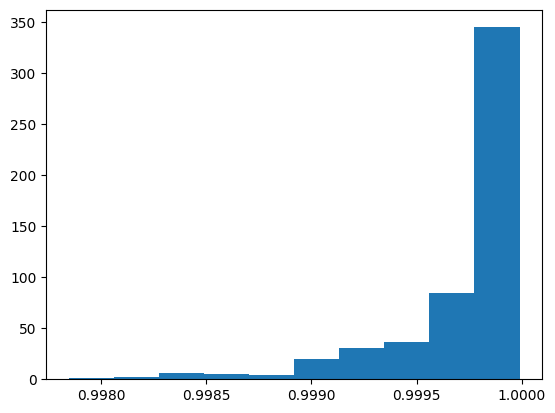

In [7]:
plt.hist(r_2)

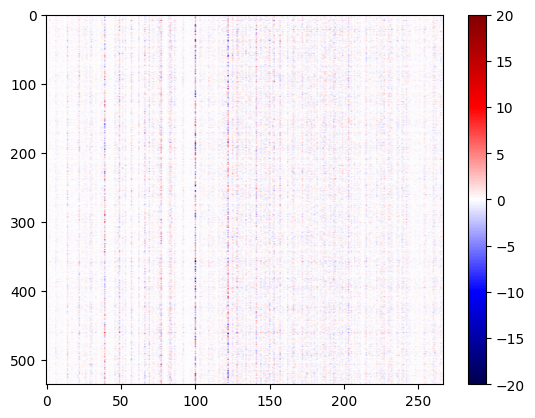

In [8]:
plt.imshow(betas, aspect='auto', cmap='seismic', origin='upper')
plt.clim(-20, 20)
plt.colorbar()

Text(0.5, 1.0, 'FN cell 3, R^2=0.9998784071705843')

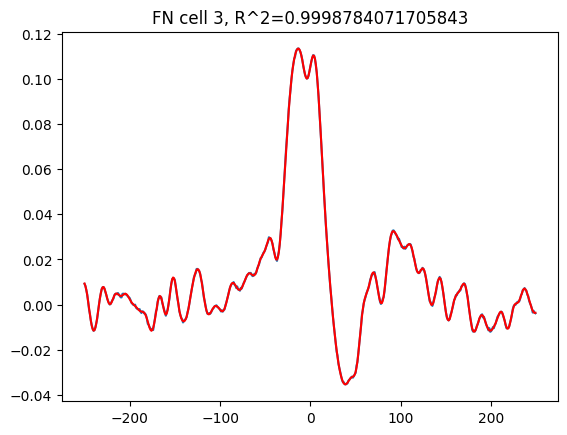

In [9]:
# plotting
t = np.arange(-250,250)

a=2
plt.plot(t, pMPC @ betas[a])
plt.plot(t, pFN[a], 'r')
plt.title(f'FN cell {a+1}, R^2={r_2[a]}')

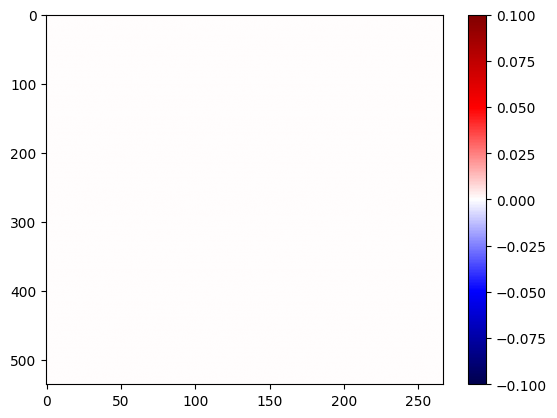

In [10]:
# Lasso
clf = linear_model.MultiTaskLasso(alpha=0.1)
clf.fit(pMPC, pFN.T)
plt.imshow(clf.coef_, aspect='auto', cmap='seismic', origin='upper')
plt.colorbar()

Text(0.5, 1.0, 'FN cell 3, R^2=0.9998784071705843')

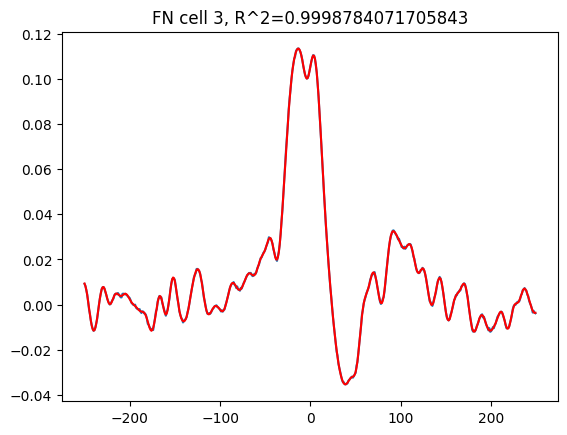

In [11]:
# plotting
t = np.arange(-250,250)

a=2
plt.plot(t, pMPC @ betas[a])
plt.plot(t, pFN[a], 'r')
plt.title(f'FN cell {a+1}, R^2={r_2[a]}')

In [35]:
pMPC.shape[1]

116

In [37]:
pMP.shape[0]

116

In [141]:
# preprocessing

data_fn = np.array(np.concatenate(data_cat_sm, axis = 0))
pFN = data_fn[:,50:550]

pMP = data_mf[:, :500]
pPC = data_pc[:, :500]

pMPC = np.vstack((-pPC, pMP))
pMPC = pMPC.T

In [142]:
# Make MF positive beta , PC beta negative

for type in range(3):

    if type == 1:
        pMPC = pPC.T
    elif type == 2:
        pMPC = pMP.T
    
    betas_pn = []
    r_2_pn = []
    resid_t = []
    for a in range(len(pFN)):
        pFN[a] = pFN[a] - np.mean(pFN[a][:100])
        # pFN[a] = pFN[a] - np.mean(pFN[a])
        beta, resid = optimize.nnls(pMPC, pFN[a])
        resid2 = resid **2
        r_s = 1 - resid2 / (pFN[a].size * pFN[a].var())
        betas_pn.append(beta)
        r_2_pn.append(r_s)
        resid_t.append(resid)
    
    if pMPC.shape[1] == pMP.shape[0]:
        betas_pn2 = np.array(betas_pn)
        r_2_pn2 = np.array(r_2_pn)
        resid_t2 = np.array(resid_t)
    elif pMPC.shape[1] == pPC.shape[0]:
        betas_pn3 = np.array(betas_pn) * -1
        r_2_pn3 = np.array(r_2_pn)
        resid_t3 = np.array(resid_t)
    else:
        betas_pn1 = np.array(betas_pn)
        # betas_pn1[:, :pPC.shape[0]] = betas_pn1[:, :pPC.shape[0]] * -1
        r_2_pn1 = np.array(r_2_pn)
        resid_t1 = np.array(resid_t)

betas_pn1[:, :pPC.shape[0]] = betas_pn1[:, :pPC.shape[0]] * -1

In [42]:
# # Make MF positive beta , PC beta negative
# # pMPC = pPC.T

# if pMPC.shape[1] == pMP.shape[0]:
#     lower_bounds = np.zeros(pMP.shape[0])
#     upper_bounds = np.tile(np.inf, pMP.shape[0])
# elif pMPC.shape[1] == pPC.shape[0]:
#     lower_bounds = np.tile(-np.inf, pPC.shape[0])
#     upper_bounds = np.zeros(pPC.shape[0])
# else:
#     lower_bounds = np.concatenate([np.tile(-np.inf, pPC.shape[0]), np.zeros(pMP.shape[0])])
#     upper_bounds = np.concatenate([np.zeros(pPC.shape[0]), np.tile(np.inf, pMP.shape[0])])

# betas_pn = []
# r_2_pn = []
# resid_t = []
# for a in range(len(pFN)):
#     pFN[a] = pFN[a] - np.mean(pFN[a][:100])
#     # pFN[a] = pFN[a] - np.mean(pFN[a])
#     output = optimize.lsq_linear(pMPC, pFN[a], bounds=(lower_bounds, upper_bounds), max_iter = 400)
#     beta = output['x']; temp_var = output['fun'] - np.mean(output['fun'])
#     # resid = np.linalg.norm(output['fun']) ** 2
#     resid = np.linalg.norm(temp_var) ** 2
    
#     r_s = 1 - resid / (pFN[a].size * pFN[a].var())
#     betas_pn.append(beta)
#     r_2_pn.append(r_s)
#     resid_t.append(resid)

# if pMPC.shape[1] == pMP.shape[0]:
#     betas_pn2 = np.array(betas_pn)
#     r_2_pn2 = np.array(r_2_pn)
#     resid_t2 = np.array(resid_t)
# elif pMPC.shape[1] == pPC.shape[0]:
#     betas_pn3 = np.array(betas_pn)
#     r_2_pn3 = np.array(r_2_pn)
#     resid_t3 = np.array(resid_t)
# else:
#     betas_pn1 = np.array(betas_pn)
#     r_2_pn1 = np.array(r_2_pn)
#     resid_t1 = np.array(resid_t)

(0.0, 1.0)

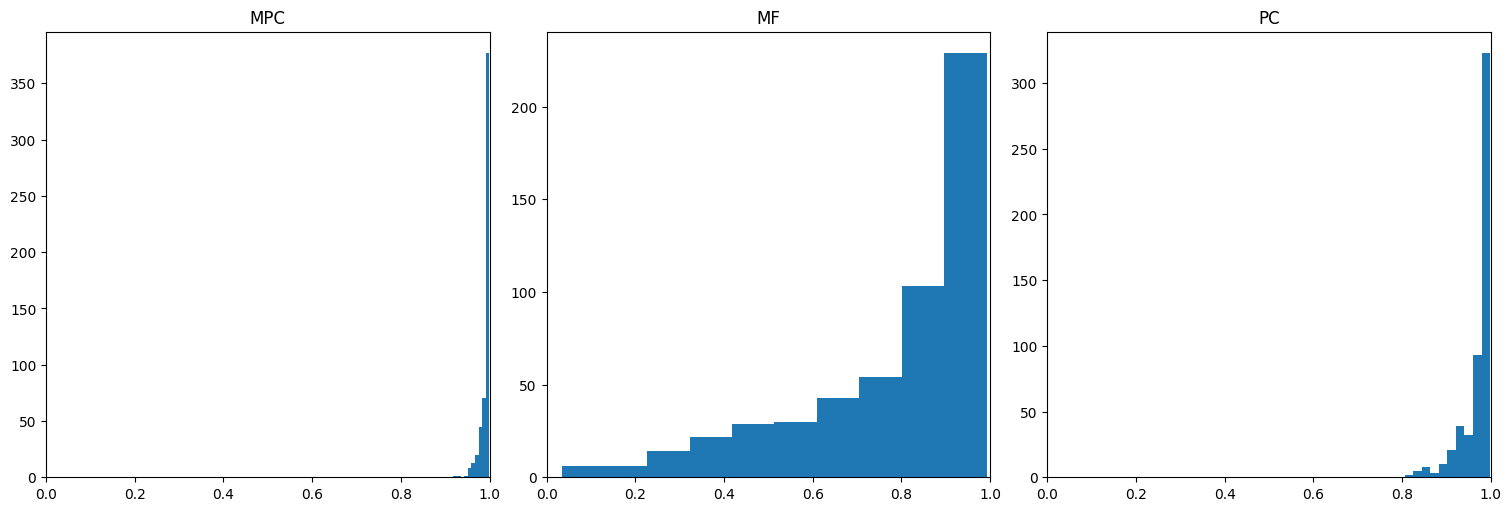

In [143]:
fig = plt.figure(constrained_layout=True,figsize=(15,5))

ax = fig.add_subplot(1, 3, 1)
ax.hist(r_2_pn1)
ax.set_title('MPC')
ax.set_xlim(0, 1)
ax = fig.add_subplot(1, 3, 2)
ax.hist(r_2_pn2)
ax.set_title('MF')
ax.set_xlim(0, 1)
ax = fig.add_subplot(1, 3, 3)
ax.hist(r_2_pn3)
ax.set_title('PC')
ax.set_xlim(0, 1)

In [155]:
mr1 = round(np.mean(r_2_pn1), 2)
mr2 = round(np.mean(r_2_pn2), 2)
mr3 = round(np.mean(r_2_pn3), 2)

stdr1 = round(np.std(r_2_pn1), 2)
stdr2 = round(np.std(r_2_pn2), 2)
stdr3 = round(np.std(r_2_pn3), 2)

(0.0, 1.0)

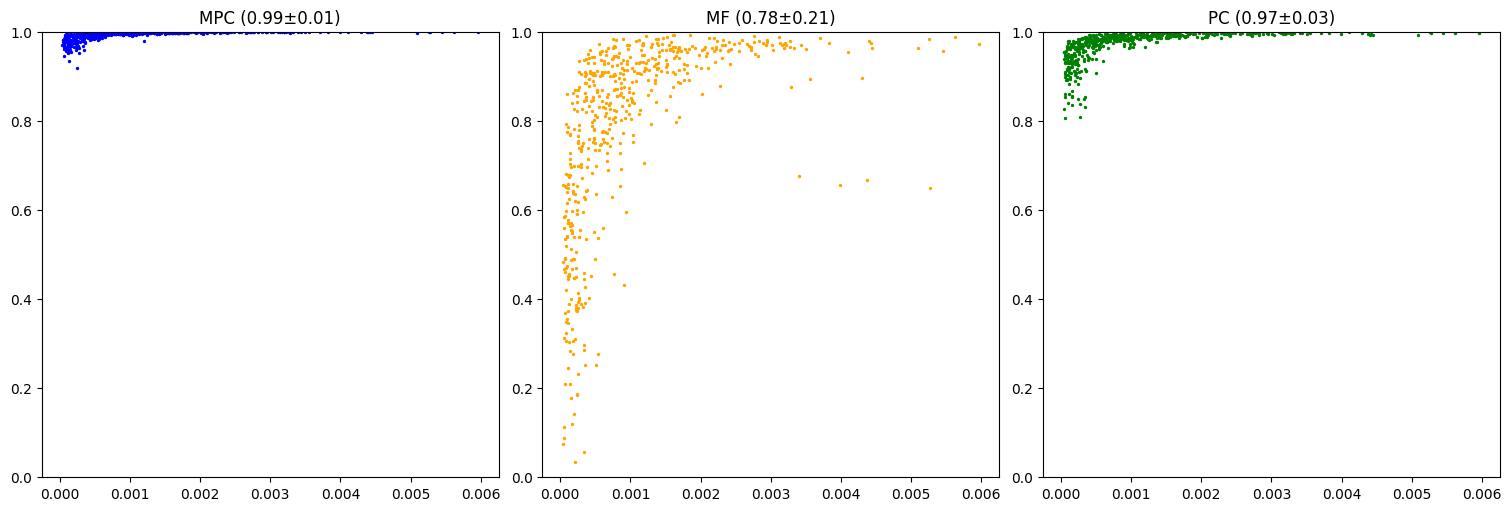

In [158]:
fig = plt.figure(constrained_layout=True,figsize=(15,5))

ax = fig.add_subplot(1, 3, 1)
ax.scatter(pFN.var(axis=1), r_2_pn1, 2,'b')
ax.set_title(f'MPC ({mr1}\u00B1{stdr1})')
ax.set_ylim(0, 1)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(pFN.var(axis=1), r_2_pn2, 2, 'orange')
ax.set_title(f'MF ({mr2}\u00B1{stdr2})')
ax.set_ylim(0, 1)
ax = fig.add_subplot(1, 3, 3)
ax.scatter(pFN.var(axis=1), r_2_pn3, 2, 'g')
ax.set_title(f'PC ({mr3}\u00B1{stdr3})')
ax.set_ylim(0, 1)

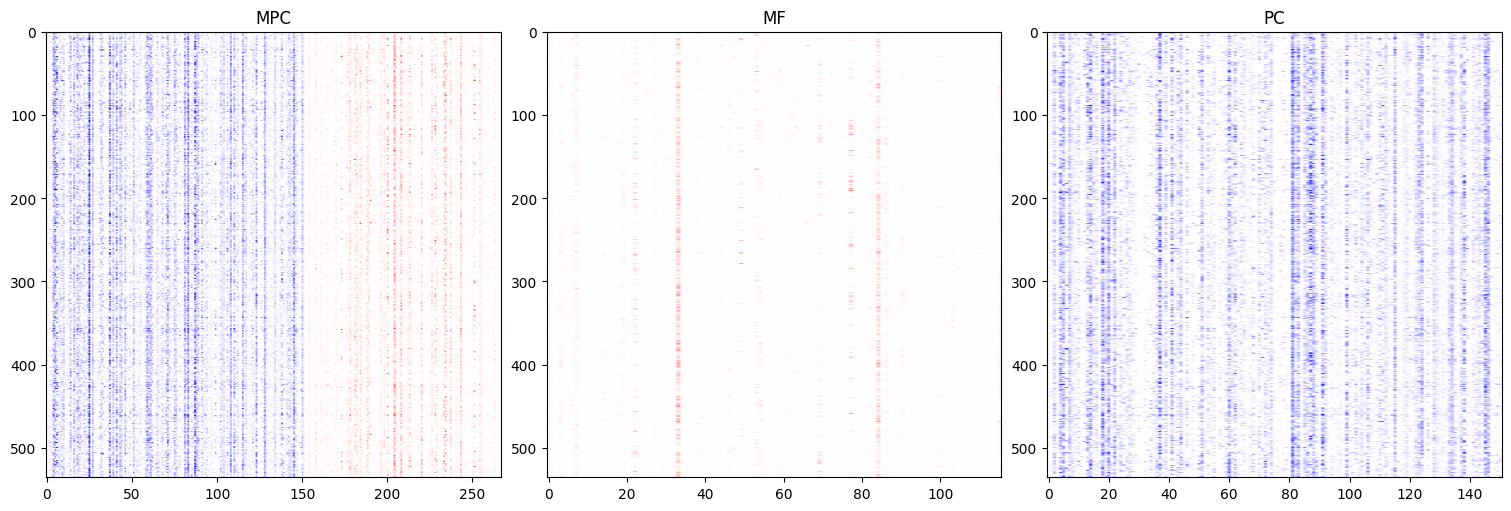

In [148]:
fig = plt.figure(constrained_layout=True,figsize=(15,5))

ax1 = fig.add_subplot(1, 3, 1)
fig1 = ax1.imshow(betas_pn1, aspect='auto', cmap='seismic', origin='upper')
ax1.set_title('MPC')
fig1.set_clim(-10, 10)

ax2 = fig.add_subplot(1, 3, 2)
fig2 = ax2.imshow(betas_pn2, aspect='auto', cmap='seismic', origin='upper')
ax2.set_title('MF')
fig2.set_clim(-10, 10)

ax3 = fig.add_subplot(1, 3, 3)
fig3 = ax3.imshow(betas_pn3, aspect='auto', cmap='seismic', origin='upper')
ax3.set_title('PC')
fig3.set_clim(-10, 10)


# plt.colorbar()

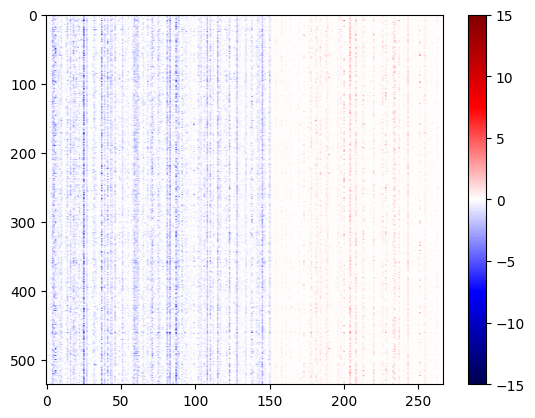

In [149]:
plt.imshow(betas_pn1, aspect='auto', cmap='seismic', origin='upper')
plt.clim(-15, 15)
plt.colorbar()

0.0
-1.1102230246251565e-16
0.024553368797591808
0.027298979996071084
0.027298979996071084


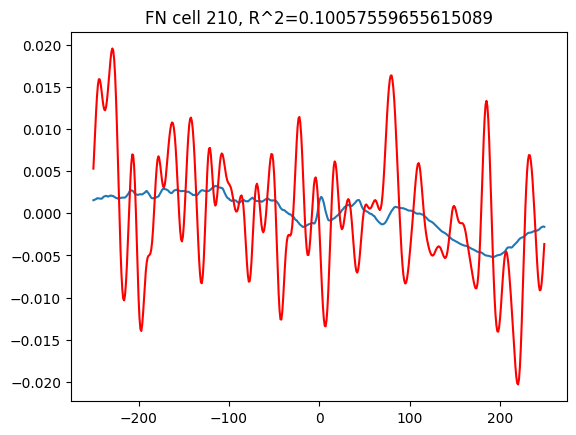

In [21]:
# plotting
t = np.arange(-250,250)

a=209
plt.plot(t, pMPC @ betas_pn[a])
plt.plot(t, pFN[a], 'r')
plt.title(f'FN cell {a+1}, R^2={r_2_pn[a]}')
print(np.mean(pMPC @ betas_pn[a]) * 500)
print(np.mean(pFN[a]) * 500)
print(np.sum((pMPC @ betas_pn[a] - pFN[a]) ** 2))
print(pFN[a].size * pFN[a].var())
print(np.sum((pFN[a] - np.mean(pFN[a])) ** 2))

In [22]:
np.argsort(r_2_pn)

array([360, 209, 245, 276, 293,  94, 295,  19, 161, 483,  89,  73,  27,
       159, 172, 429, 214, 496, 353, 228, 427, 482, 226, 311, 281, 147,
       140, 416, 425, 445, 168, 358, 349, 223,  97, 235, 494,  86, 527,
       286, 219,  22, 432, 357,  80, 365, 164,  30, 207,  18, 362, 369,
       290, 190, 141,  92, 499,  25, 488, 156, 178, 341, 101,  24, 475,
       348, 446, 436, 492, 420, 205,  13, 274, 491, 169, 298, 343, 148,
        75, 418, 531, 302, 434, 415, 367, 408, 152, 291,  91, 105, 233,
       312, 243, 495,  23, 423,  58, 378, 244, 300, 157, 229, 142, 493,
       406, 153,  14, 176, 231, 487, 410, 426, 485, 215, 220,  62,   8,
         6, 513,  81,  85, 239, 162, 282, 512, 421, 469, 379, 287,  21,
       490,  43, 257, 177, 160,   0, 473,   4, 477,  95, 288, 224, 424,
        67, 461,  90,  42,  34, 402,  87, 465, 476, 470, 110, 351, 409,
       299, 165,   1,  71, 125, 306, 221, 366,  63, 503, 238, 166, 507,
       294, 232, 227, 347, 440, 411, 433, 154, 138, 428, 404, 11